<a href="https://colab.research.google.com/github/mudnighrs/object_detection/blob/main/AIMSdtu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install -U gdown

In [ ]:
# import gdown

# file_id = "1MdmkhdkhNjXM_PZDaZ9kRuoaS80vsZ8_"
# gdown.download(f"https://drive.google.com/uc?id={file_id}", "dataset.zip", quiet=False)

In [ ]:
import zipfile

# with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
with zipfile.ZipFile("/content/drive/MyDrive/ssl_dataset.zip", 'r') as zip_ref:
     zip_ref.extractall("unzipped_dataset")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls ./unzipped_dataset/ssl_dataset/

Labels.json  train.X1  train.X2  train.X3  train.X4  val.X


In [ ]:
contrastive learning method-SimCLR

#**Contrastive learning method-SimCLR**



In [ ]:


import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

train_dirs = [f"./unzipped_dataset/ssl_dataset/train.X{i}" for i in range(  1, 5)]
val_dir = "./unzipped_dataset/ssl_dataset/val.X"

pretrain_transform = transforms.Compose([
    transforms.Resize(( 224, 224)),
    transforms.ToTensor()
])
val_transform = transforms.Compose([
    transforms.Resize(( 224 , 224)),
    transforms.ToTensor()
])

unlabeled_datasets = []
for td in train_dirs:
    if os.path.isdir(td):
        print(f" Found: {td}")
        ds = datasets.ImageFolder(root=td, transform=pretrain_transform)
        unlabeled_datasets.append(ds)
    else:
        print(f" Not found: {td}")

assert len(unlabeled_datasets) > 0, "No training directories found!"

pretrain_dataset = ConcatDataset(unlabeled_datasets)
pretrain_loader = DataLoader(pretrain_dataset, batch_size=256, shuffle=True, num_workers=2)

val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

 Found: ./unzipped_dataset/ssl_dataset/train.X1
 Found: ./unzipped_dataset/ssl_dataset/train.X2
 Found: ./unzipped_dataset/ssl_dataset/train.X3
 Found: ./unzipped_dataset/ssl_dataset/train.X4


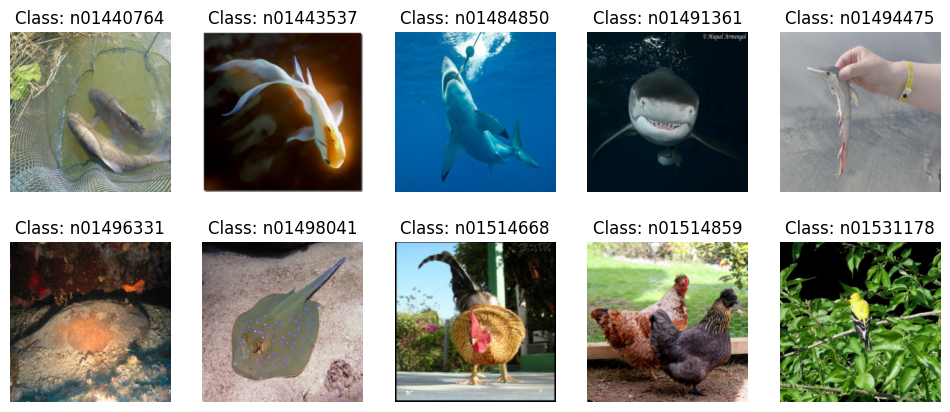

In [ ]:

import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder

val_dataset = ImageFolder(root=val_dir, transform=val_transform)
classes = val_dataset.classes

fig, axs = plt.subplots(2, 5, figsize=(12,5))
for i, ax in enumerate(axs.flatten()):
    cls = classes[i % len(classes)]
    img_idx = next(idx for idx, (_, label) in enumerate(val_dataset) if val_dataset.classes[label] == cls)
    img, _ = val_dataset[img_idx]
    ax.imshow(img.permute(1,2,0))
    ax.set_title(f"Class: {cls}")
    ax.axis('off')
plt.show()

In [ ]:
import torchvision.transforms as transforms

simclr_augment = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.08, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.8, 0.8, 0.8, 0.2),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=23),
    transforms.ToTensor()
])

class TwoCropTransform:
    """Generate two augmented views of an image."""
    def __init__(self, base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        x1 = self.base_transform(x)
        x2 = self.base_transform(x)
        return x1, x2

In [ ]:
from torch.utils.data import Dataset

class SimCLRDataset(Dataset):
    def __init__(self, image_folder, transform):
        self.dataset = image_folder
        self.transform = TwoCropTransform(transform)
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        img, _ = self.dataset[idx]  # ignore label
        x1, x2 = self.transform(img)
        return x1, x2

In [ ]:
import torch.nn as nn
import torchvision.models as models

class SimCLRModel(nn.Module):
    def __init__(self, proj_dim=128):
        super().__init__()
        resnet = models.resnet50(weights=None)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])
        self.projection = nn.Sequential(
            nn.Linear(resnet.fc.in_features, 512),
            nn.ReLU(),
            nn.Linear(512, proj_dim)
        )
    def forward(self, x):
        h = self.encoder(x).squeeze()
        z = self.projection(h)
        return z

In [ ]:
import torch.nn.functional as F

def nt_xent_loss(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    N = z1.shape[0]
    z = torch.cat([z1, z2], dim=0)  # 2N x D

    sim = torch.matmul(z, z.T) / temperature

    mask = torch.eye(2 * N, device=z.device).bool()
    sim.masked_fill_(mask, float('-inf'))

    positives = torch.exp(torch.sum(z1 * z2, dim=-1) / temperature)
    positives = torch.cat([positives, positives], dim=0)

    denom = torch.sum(torch.exp(sim), dim=1)
    loss = -torch.log(positives / denom)
    return loss.mean()

**I STOPPED TRAINING AFTER 1 HOUR**





In [ ]:
# I STOPPED TRAINING AFTER 1 HOUR
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dirs = [f"./unzipped_dataset/ssl_dataset/train.X{i}" for i in range(1, 5)]
transform = simclr_augment

from torch.utils.data import ConcatDataset
all_datasets = []
for td in train_dirs:
    if os.path.isdir(td):
        print(f"Using {td}")
        ds = datasets.ImageFolder(root=td)
        wrapped = SimCLRDataset(ds, transform)
        all_datasets.append(wrapped)

train_dataset = ConcatDataset(all_datasets)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, drop_last=True)

model = SimCLRModel(proj_dim=128).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 2
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for step, (x1, x2) in enumerate(train_loader):
        x1, x2 = x1.to(device), x2.to(device)

        z1 = model(x1)
        z2 = model(x2)

        loss = nt_xent_loss(z1, z2, temperature=0.5)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if step % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{step}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f" Epoch [{epoch+1}/{epochs}] completed, Avg Loss: {avg_loss:.4f}")


Using ./unzipped_dataset/ssl_dataset/train.X1
Using ./unzipped_dataset/ssl_dataset/train.X2
Using ./unzipped_dataset/ssl_dataset/train.X3
Using ./unzipped_dataset/ssl_dataset/train.X4
Epoch [1/2], Step [0/8125], Loss: 3.4509
Epoch [1/2], Step [10/8125], Loss: 3.3920
Epoch [1/2], Step [20/8125], Loss: 3.4258
Epoch [1/2], Step [30/8125], Loss: 3.4512
Epoch [1/2], Step [40/8125], Loss: 3.4332
Epoch [1/2], Step [50/8125], Loss: 3.4337
Epoch [1/2], Step [60/8125], Loss: 3.4194
Epoch [1/2], Step [70/8125], Loss: 3.4436
Epoch [1/2], Step [80/8125], Loss: 3.4304
Epoch [1/2], Step [90/8125], Loss: 3.4594
Epoch [1/2], Step [100/8125], Loss: 3.5557
Epoch [1/2], Step [110/8125], Loss: 3.4450
Epoch [1/2], Step [120/8125], Loss: 3.4306
Epoch [1/2], Step [130/8125], Loss: 3.4348
Epoch [1/2], Step [140/8125], Loss: 3.4364
Epoch [1/2], Step [150/8125], Loss: 3.4273
Epoch [1/2], Step [160/8125], Loss: 3.4389
Epoch [1/2], Step [170/8125], Loss: 3.4044
Epoch [1/2], Step [180/8125], Loss: 3.4435
Epoch [1/2

KeyboardInterrupt: 

In [ ]:
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = model.encoder.to(device)
for param in encoder.parameters():
    param.requires_grad = False
encoder.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])
dataset = datasets.ImageFolder(root='./unzipped_dataset/ssl_dataset/val.X', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
features_list, labels_list = [], []
with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        feats = encoder(images)
        feats = feats.view(feats.size(0), -1)
        features_list.append(feats.cpu())
        labels_list.append(labels)
features = torch.cat(features_list, dim=0)
labels = torch.cat(labels_list, dim=0)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

num_classes = len(dataset.classes)
classifier = nn.Linear(2048, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)

features = features.to(device)
labels = labels.to(device)
feat_dataset = TensorDataset(features, labels)
feat_loader = DataLoader(feat_dataset, batch_size=128, shuffle=True)

num_epochs = 100
losses = []

for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0
    for feat_batch, label_batch in feat_loader:
        optimizer.zero_grad()
        outputs = classifier(feat_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * feat_batch.size(0)

    epoch_loss = running_loss / len(feat_loader.dataset)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")




Epoch [1/100], Loss: 5.8074
Epoch [2/100], Loss: 5.0177
Epoch [3/100], Loss: 4.9729
Epoch [4/100], Loss: 4.8944
Epoch [5/100], Loss: 4.8530
Epoch [6/100], Loss: 4.8242
Epoch [7/100], Loss: 4.8049
Epoch [8/100], Loss: 4.7853
Epoch [9/100], Loss: 4.7321
Epoch [10/100], Loss: 4.7426
Epoch [11/100], Loss: 4.8317
Epoch [12/100], Loss: 4.6554
Epoch [13/100], Loss: 4.8259
Epoch [14/100], Loss: 4.8804
Epoch [15/100], Loss: 4.6063
Epoch [16/100], Loss: 4.6314
Epoch [17/100], Loss: 4.7146
Epoch [18/100], Loss: 4.7654
Epoch [19/100], Loss: 4.6263
Epoch [20/100], Loss: 4.5772
Epoch [21/100], Loss: 4.6584
Epoch [22/100], Loss: 4.5940
Epoch [23/100], Loss: 4.5172
Epoch [24/100], Loss: 4.5892
Epoch [25/100], Loss: 4.8684
Epoch [26/100], Loss: 4.7203
Epoch [27/100], Loss: 4.4371
Epoch [28/100], Loss: 4.4660
Epoch [29/100], Loss: 4.6641
Epoch [30/100], Loss: 4.4831
Epoch [31/100], Loss: 4.5209
Epoch [32/100], Loss: 4.3070
Epoch [33/100], Loss: 4.3896
Epoch [34/100], Loss: 4.3778
Epoch [35/100], Loss: 4

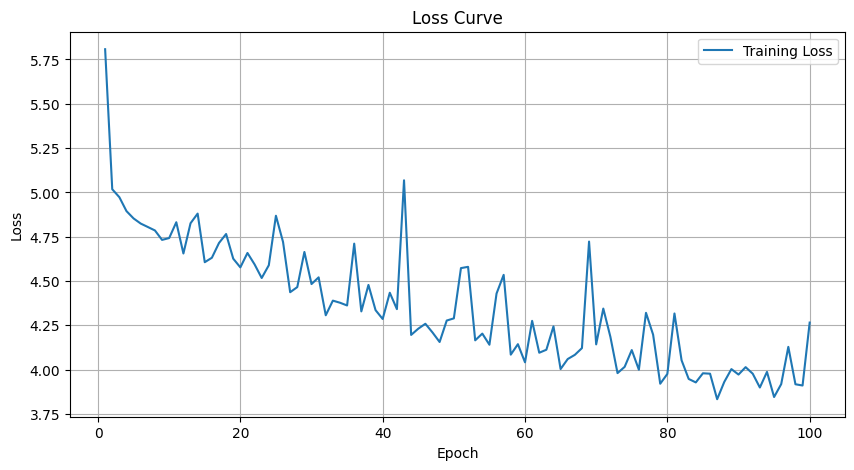

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
classifier.eval()
with torch.no_grad():
    outputs = classifier(features)
preds = outputs.argmax(dim=1).cpu().numpy()
labels_np = labels.cpu().numpy()

accuracy = accuracy_score(labels_np, preds)
macro_f1 = f1_score(labels_np, preds, average='macro')
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1: {macro_f1:.4f}")

Accuracy: 0.1428
Macro F1: 0.1132


#**Masked Image Modelling method (MASKED AUTOENCODER)**

In [ ]:
import torch
import os
from torchvision import transforms, datasets
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.utils.data import DataLoader, ConcatDataset

pretrain_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])

root = "/content/unzipped_dataset/ssl_dataset"
train_parts = ["train.X1", "train.X2", "train.X3", "train.X4"]
pretrain_datasets = []
for part in train_parts:
    ds = datasets.ImageFolder(os.path.join(root, part), transform=pretrain_transform)
    pretrain_datasets.append(ds)
pretrain_data = ConcatDataset(pretrain_datasets)
pretrain_loader = DataLoader(pretrain_data, batch_size=32, shuffle=True, num_workers=2)


In [ ]:
import torch.nn as nn
import torchvision.models as models

encoder = models.resnet50(weights=None)
encoder.fc = nn.Identity()

class Decoder(nn.Module):
    def __init__(self, latent_dim=2048):
        super().__init__()

        self.fc = nn.Linear(latent_dim, 512*7*7)
        self.up = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.ReLU(),
            nn.ConvTranspose2d(128,  64, kernel_size=4, stride=2, padding=1),  # 28x28 -> 56x56
            nn.ReLU(),
            nn.ConvTranspose2d( 64,   3, kernel_size=4, stride=4, padding=0),  # 56x56 -> 224x224
        )
    def forward(self, x):
        x = self.fc(x)            # (N, latent_dim) -> (N, 512*7*7)
        x = x.view(-1, 512, 7, 7)
        x = self.up(x)            # (N, 3, 224, 224)
        return x

decoder = Decoder(latent_dim=2048)


In [ ]:
import torch.optim as optim


optimizer = optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-4, weight_decay=1e-5
)


In [ ]:
import torch.nn.functional as F

def mask_image(x, mask_ratio=0.75):

    B, C, H, W = x.size()
    patch_size = 16
    device = x.device


    num_patches = (H // patch_size) * (W // patch_size)
    mask = torch.rand(B, num_patches, device=device) < mask_ratio
    mask = mask.view(B, H//patch_size, W//patch_size, 1, 1)
    mask = mask.repeat(1,1,1,patch_size,patch_size).view(B, 1, H, W)

    return x * (~mask)

encoder = encoder.to(device)
decoder = decoder.to(device)

encoder.train(); decoder.train()
for images, _ in pretrain_loader:
    images = images.to(device)
    masked_imgs = mask_image(images, mask_ratio=0.75)
    features = encoder(masked_imgs)
    recon = decoder(features)

    loss = F.mse_loss(recon, images)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


In [ ]:
with open('/content/unzipped_dataset/ssl_dataset/Labels.json') as f:
    labels = json.load(f)
    print("Sample label keys:", list(labels.keys())[:5])


Sample label keys: ['n01968897', 'n01770081', 'n01818515', 'n02011460', 'n01496331']


In [ ]:
import json
import os
import json
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

with open(os.path.join(root, "Labels.json")) as f:
    labels = json.load(f)

val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)),
])



class SSLMultiRootDataset(Dataset):
    def __init__(self, root_list, label_json, transform=None):
        with open(label_json, 'r') as f:
            raw_classnames = json.load(f)

        self.classname_to_index = {
            class_name: idx for idx, class_name in enumerate(sorted(raw_classnames))
        }

        self.transform = transform or transforms.ToTensor()
        self.samples = []

        for root in root_list:
            for class_dir in os.listdir(root):
                class_path = os.path.join(root, class_dir)
                if os.path.isdir(class_path):
                    label = self.classname_to_index.get(class_dir)
                    if label is None:
                        continue
                    for fname in os.listdir(class_path):
                        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                            full_path = os.path.join(class_path, fname)
                            self.samples.append((full_path, label))

        print(f"Loaded {len(self.samples)} labeled samples from {len(self.classname_to_index)} classes.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)


train_roots = [
    '/content/unzipped_dataset/ssl_dataset/train.X1',
    '/content/unzipped_dataset/ssl_dataset/train.X2',
    '/content/unzipped_dataset/ssl_dataset/train.X3',
    '/content/unzipped_dataset/ssl_dataset/train.X4'
]

train_dataset = SSLMultiRootDataset(
    root_list=train_roots,
    label_json='/content/unzipped_dataset/ssl_dataset/Labels.json',
    transform=val_transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_dataset = SSLMultiRootDataset(
    root_list=['/content/unzipped_dataset/ssl_dataset/val.X'],
    label_json='/content/unzipped_dataset/ssl_dataset/Labels.json',
    transform=val_transform
)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

len(val_dataset), len(val_loader)


Loaded 130000 labeled samples from 100 classes.
Loaded 5000 labeled samples from 100 classes.


(5000, 157)

:**THE MODEL WAS TRAINED FOR 4 EPOCHS , I STOPPED TRAINING IN 5TH EPOCH**





In [ ]:
#THE MODEL WAS TRAINED FOR 4 EPOCHS , I STOPPED TRAINING IN 5TH EPOCH


for param in encoder.parameters():
    param.requires_grad = False

linear_head = nn.Linear(2048, 100).to(device)
optimizer_lin = torch.optim.Adam(linear_head.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

encoder.eval()
linear_head.train()

loss_per_epoch = []

epochs = 5
for epoch in range(epochs):
    running_loss = 0.0
    print(f"\n--- Epoch [{epoch+1}/{epochs}] ---")

    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)

        with torch.no_grad():
            feats = encoder(imgs)  # frozen encoder

        outputs = linear_head(feats)
        loss = criterion(outputs, labels)

        optimizer_lin.zero_grad()
        loss.backward()
        optimizer_lin.step()

        running_loss += loss.item()

        print(f"Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    loss_per_epoch.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}] Average Loss: {avg_loss:.4f}")


Streaming output truncated to the last 5000 lines.
Step [1076/4063], Loss: 4.4796
Step [1077/4063], Loss: 4.1650
Step [1078/4063], Loss: 3.9029
Step [1079/4063], Loss: 4.1331
Step [1080/4063], Loss: 4.4490
Step [1081/4063], Loss: 4.1965
Step [1082/4063], Loss: 4.3100
Step [1083/4063], Loss: 4.2502
Step [1084/4063], Loss: 4.3626
Step [1085/4063], Loss: 4.4491
Step [1086/4063], Loss: 4.7837
Step [1087/4063], Loss: 4.5300
Step [1088/4063], Loss: 4.7523
Step [1089/4063], Loss: 4.8437
Step [1090/4063], Loss: 4.2459
Step [1091/4063], Loss: 5.1668
Step [1092/4063], Loss: 4.3818
Step [1093/4063], Loss: 4.3621
Step [1094/4063], Loss: 4.4750
Step [1095/4063], Loss: 4.5732
Step [1096/4063], Loss: 5.1477
Step [1097/4063], Loss: 4.8206
Step [1098/4063], Loss: 4.2126
Step [1099/4063], Loss: 4.0908
Step [1100/4063], Loss: 4.0016
Step [1101/4063], Loss: 4.6594
Step [1102/4063], Loss: 5.0075
Step [1103/4063], Loss: 4.5251
Step [1104/4063], Loss: 4.1812
Step [1105/4063], Loss: 4.9030
Step [1106/4063], L

KeyboardInterrupt: 

In [ ]:
epochs


4

In [ ]:
len(loss_per_epoch)

4

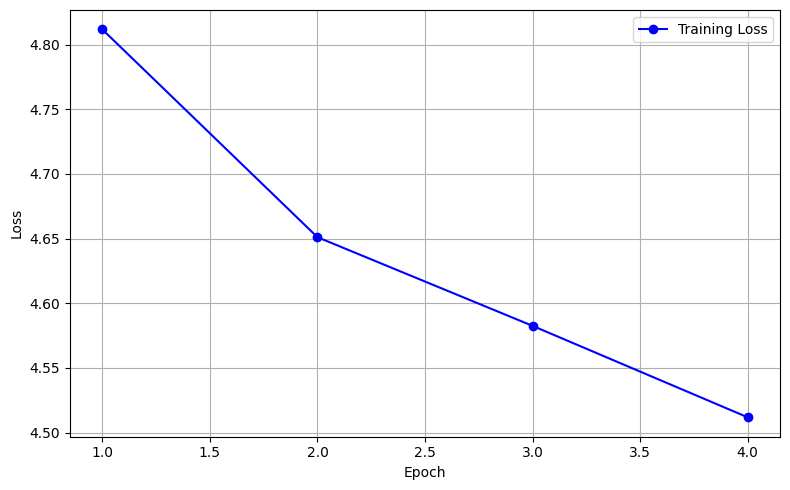

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), loss_per_epoch, marker='o', color='blue', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from PIL import Image

encoder.eval(); linear_head.eval()
all_preds, all_targets = [], []
for imgs, targets in val_loader:
    imgs = imgs.to(device)
    with torch.no_grad():
        feats = encoder(imgs)
        outputs = linear_head(feats)
    preds = outputs.argmax(dim=1).cpu().numpy()
    all_preds.extend(preds)
    all_targets.extend(targets.numpy())

acc = accuracy_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds, average='macro')
print(f"Linear Eval Accuracy: {acc:.4f}, F1-score: {f1:.4f}")


Linear Eval Accuracy: 0.0810, F1-score: 0.0674


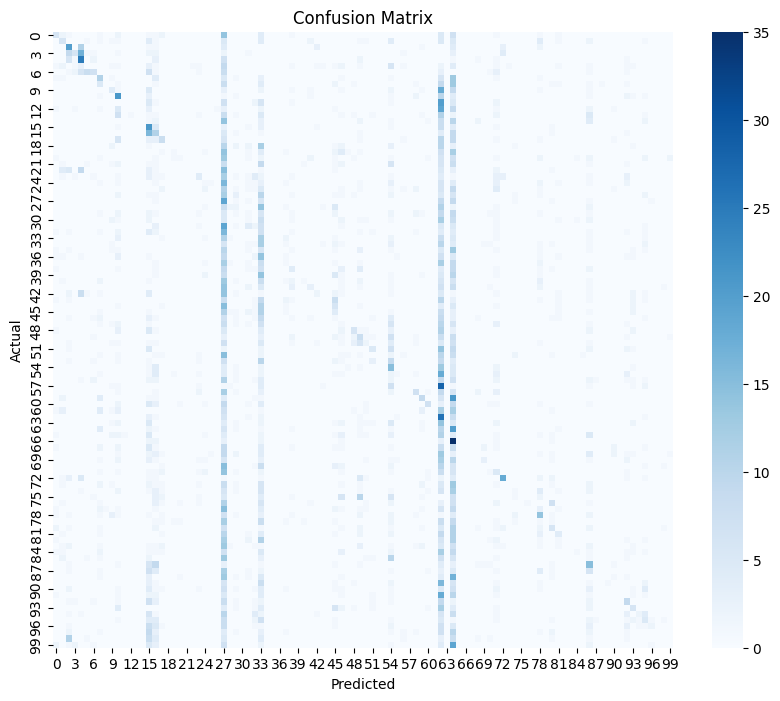

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues", annot=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
